## Data setup

<div class="alert alert-block alert-warning">
<b>⚠️</b> Don't forget to download the Kaggle token associated with your account from the Settings page: https://www.kaggle.com/settings
</div>


In [14]:
import os
from pathlib import Path

os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

!kaggle competitions download -c playground-series-s5e2
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)
!mv playground-series-s5e2.zip data/
os.chdir(data_dir)
!unzip -o playground-series-s5e2.zip
!rm playground-series-s5e2.zip
!ls -lh
os.chdir("..")


Archive:  playground-series-s5e2.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: training_extra.csv      
total 323M
-rw-rw-r-- 1 rodrigo rodrigo 2.7M Feb  3 15:41 sample_submission.csv
-rw-rw-r-- 1 rodrigo rodrigo  14M Feb  3 15:41 test.csv
-rw-rw-r-- 1 rodrigo rodrigo  23M Feb  3 15:41 train.csv
-rw-rw-r-- 1 rodrigo rodrigo 284M Feb  3 15:41 training_extra.csv


## Load data

In [15]:
import pandas as pd

train_data = pd.read_csv('data/training_extra.csv')
test_data = pd.read_csv('data/test.csv')

train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 310.0+ MB


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


In [5]:
missing_values = train_data[train_data.isna().any(axis=1)]
print(len(missing_values))
missing_values.head()

652501


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
5,500005,Adidas,Polyester,Medium,5.0,No,No,Tote,NaN,18.834692,35.99599
12,500012,Under Armour,Nylon,Medium,1.0,NaN,No,Messenger,Pink,18.462269,130.22309
21,500021,Jansport,Leather,Small,7.0,NaN,Yes,Backpack,Red,13.923496,17.20743
22,500022,NaN,Nylon,Large,5.0,No,No,Tote,Pink,23.626700,42.40687
26,500026,NaN,Polyester,Large,7.0,Yes,No,Messenger,Red,5.000000,139.71219


In [6]:
train_data.describe()

,id,Compartments,Weight Capacity (kg),Price
count,3.694318e+06,3.694318e+06,3.692648e+06,3.694318e+06
mean,2.347158e+06,5.434022e+00,1.800883e+01,8.135820e+01
std,1.066458e+06,2.893227e+00,6.974541e+00,3.893050e+01
min,5.000000e+05,1.000000e+00,5.000000e+00,1.500000e+01
25%,1.423579e+06,3.000000e+00,1.206854e+01,4.747778e+01
50%,2.347158e+06,5.000000e+00,1.805243e+01,8.098592e+01
75%,3.270738e+06,8.000000e+00,2.398580e+01,1.148434e+02
max,4.194317e+06,1.000000e+01,3.000000e+01,1.500000e+02


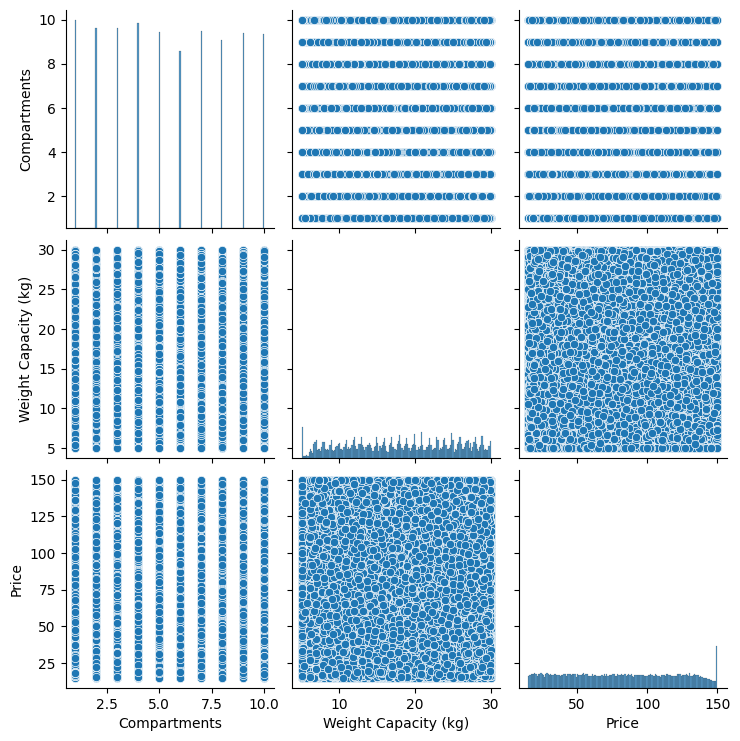

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['Compartments', 'Weight Capacity (kg)', 'Price']

df_numeric = train_data[numeric_cols].dropna()

sns.pairplot(df_numeric)


## Encode categorical features and define features and targets

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

train_data.dropna(inplace=True)
label_encoders = {}
for col in ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le

X = train_data.drop('Price', axis=1)
y = train_data['Price']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

model = DecisionTreeRegressor(random_state=1, max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {mse**0.5:.2f}")



Mean Squared Error: 1505.68
Root Mean Squared Error: 38.80


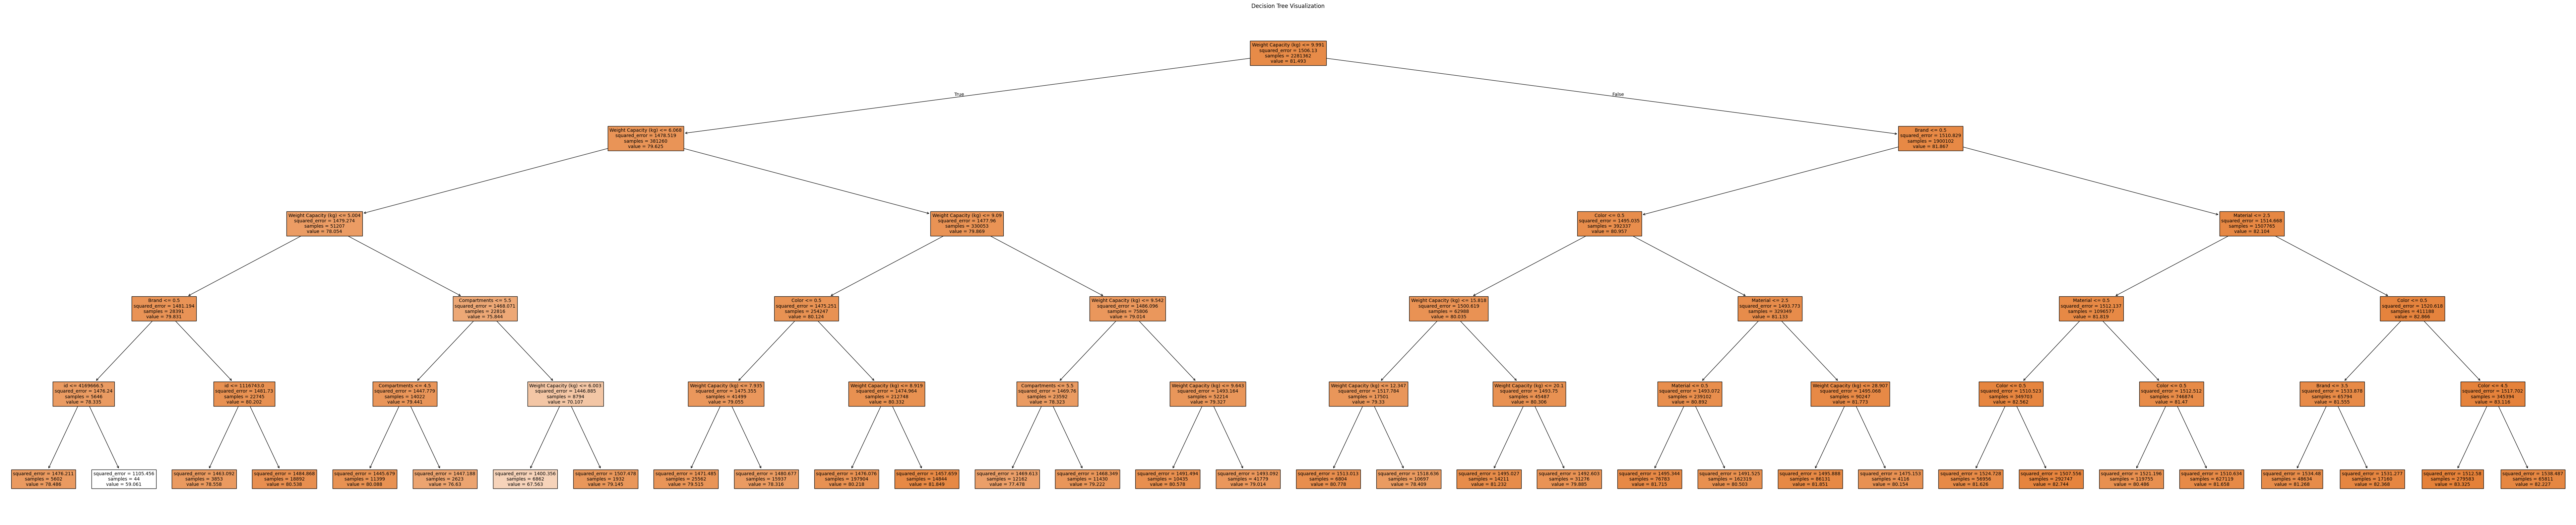

In [12]:
from sklearn.tree import export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(100, 20))
plot_tree(model, filled=True, feature_names=X.columns, fontsize=10, max_depth=5)
plt.title("Decision Tree Visualization")
plt.show()
